# Referral Rates

As a data scientist/analyst, we must have the referral rates by area which we can then use to feed into the D&C model for acute.
The referral rate is the number of referrals per appointment per year. We wish to understand the volume of referrals created by the area that stay within the area (ESNEFT and WSFT) and outside the area.


## Importing libraries

In [10]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# std library
import yaml

#stats/arrays
import pandas as pd
import matplotlib.pyplot as plt

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import PlotCounter
import plotly.graph_objects as go

## Loading  Data from Data Catalog

In [2]:
# load data catalog
data_catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
# keeps track of plot numbers
plot_counter = PlotCounter(name="referral_rate") 

### Loading the Referrals dataframe from 2022-23

In [3]:
# Loading the Referrals dataframe from 2022
referral_data_catalog_entry_22 = data_catalog.single_data_sources[2]
outpatient_referrals_22 = referral_data_catalog_entry_22.load()
print(referral_data_catalog_entry_22.zip_file.namelist())
print(outpatient_referrals_22.shape)

# Removing unnecessary columns
outpatient_referrals_22 = outpatient_referrals_22.drop(columns=['Unnamed: 13' , 'Unnamed: 14', 'Unnamed: 15'])

['Annual CSV 2022-23 including revisions Oct 22- Feb 23 final 1.csv']
(97108, 16)


In [4]:
# Loading the Referrals dataframe from 2023
referral_data_catalog_entry_23 = data_catalog.single_data_sources[1]
outpatient_referrals_23 = referral_data_catalog_entry_23.load()
print(referral_data_catalog_entry_23.zip_file.namelist())
print(outpatient_referrals_23.shape)

['Annual CSV 2023-24 Published October 2023 HJYTR.csv']
(42436, 13)


In [5]:
# Merging both the dataframes
referrals_df = pd.concat([outpatient_referrals_22, outpatient_referrals_23], ignore_index=True)
print(referrals_df.shape)

# Taking record from September/2022 to August/2023
required_time = ['MRR-September-2022', 'MRR-October-2022','MRR-November-2022', 'MRR-December-2022', 'MRR-January-2023',
       'MRR-February-2023', 'MRR-March-2023', 'MRR-April-2023','MRR-May-2023', 'MRR-June-2023', 'MRR-July-2023','MRR-August-2023']

referrals_df = referrals_df[referrals_df['Periodname'].isin(required_time)].reset_index().drop(columns=['index'])
print(referrals_df.shape)


(139544, 13)
(99577, 13)


In [244]:
referrals_df.head()

,Periodname,Provider Parent org code,Provider Parent name,Provider Org code,Provider Org name,Commissioner Parent Org Code,Commissioner Parent Org Name,Commissioner Org Code,Commissioner Org Name,Op Gprefsmade M,Op Otherrefsmade M,Op Gprefsmade Ga M,Op Otherrefsmade Ga M
0,MRR-September-2022,NaN,NaN,7A1,BETSI CADWALADR UNIVERSITY LHB,QYG,NHS CHESHIRE AND MERSEYSIDE INTEGRATED CARE BOARD,02E,NHS WARRINGTON (SUB ICB LOCATION),1,0,1,0
1,MRR-September-2022,NaN,NaN,7A1,BETSI CADWALADR UNIVERSITY LHB,QYG,NHS CHESHIRE AND MERSEYSIDE INTEGRATED CARE BOARD,12F,NHS WIRRAL (SUB ICB LOCATION),1,0,1,0
2,MRR-September-2022,NaN,NaN,7A1,BETSI CADWALADR UNIVERSITY LHB,QYG,NHS CHESHIRE AND MERSEYSIDE INTEGRATED CARE BOARD,27D,NHS CHESHIRE (SUB ICB LOCATION),5,0,5,0
3,MRR-September-2022,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,A4M8P,BUCKSHAW HOSPITAL,QHM,NHS NORTH EAST AND NORTH CUMBRIA INTEGRATED CA...,00L,NHS NORTHUMBERLAND (SUB ICB LOCATION),25,0,25,0
4,MRR-September-2022,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,A4M8P,BUCKSHAW HOSPITAL,QHM,NHS NORTH EAST AND NORTH CUMBRIA INTEGRATED CA...,00N,NHS SOUTH TYNESIDE (SUB ICB LOCATION),10,0,10,0


In [9]:
# Getting the Provider parent org code for SNEE
drow = referrals_df[referrals_df['Provider Parent name'] == 'NHS SUFFOLK AND NORTH EAST ESSEX INTEGRATED CARE BOARD']
#print(drow['Provider Parent org code'])

In [7]:
# Only taking required columns and dropping the rest
needed_cols = ['Commissioner Org Code','Op Gprefsmade M','Op Otherrefsmade M']
referrals_df_1 = referrals_df[needed_cols].copy()

# Keeping provider records for SNEE-ICB and dropping rest
#snee_code = ['QJG']
#snee_referrals = referrals_df[referrals_df['Provider Parent org code'].isin(snee_code)].reset_index().drop(columns=['index'])

# Replacing the code with SNEE-ICB
#snee_referrals['Provider Parent org code'] = snee_referrals['Provider Parent org code'].map({'QJG' : 'SNEE-ICB'})


# Keeping commmissioned records for SNEE-sub-icb and dropping rest
sub_icb_code = ['06L','07K','06T']
snee_referrals = referrals_df_1[referrals_df_1['Commissioner Org Code'].isin(sub_icb_code)].reset_index().drop(columns=['index'])

In [8]:
snee_referrals_groupby = snee_referrals.rename(columns={'Op Gprefsmade M':'GP_Ref', 'Op Otherrefsmade M':'Others_ref'}).groupby(['Commissioner Org Code']).sum()
snee_referrals_groupby

,GP_Ref,Others_ref
Commissioner Org Code,,
06L,77040,71175
06T,41337,40122
07K,50852,49227


### Loading the Appointments Dataframe

In [18]:
gp_appts_catalog_entry = data_catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

#Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


In [ ]:
# Taking record from September/2022 to August/2023
required_months = ['SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023','MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023']
filtered_appointments_df = combined_df[combined_df['APPOINTMENT_MONTH'].isin(required_months)]


# Merging HCP-TYPE= 'Unknown' into 'Other'
filtered_appointments_df['HCP_TYPE'] = filtered_appointments_df['HCP_TYPE'].replace({'Unknown':'Other Practice staff'})


# Filtering for SNEE-sub-ICB and appointment status
snee_appointments = filtered_appointments_df[(filtered_appointments_df['SUB_ICB_LOCATION_CODE'].isin(sub_icb_code)) & 
                                                (filtered_appointments_df['APPT_STATUS']=='Attended')]


# Only taking required columns and dropping the rest
required_cols = ['SUB_ICB_LOCATION_CODE','HCP_TYPE','COUNT_OF_APPOINTMENTS']
snee_appointments = snee_appointments[required_cols].copy().reset_index().drop(columns={'index'})

In [20]:
# Making a Pivot table for better presentation of data
snee_appointments_pivot = snee_appointments.pivot_table(index=['SUB_ICB_LOCATION_CODE'], columns=['HCP_TYPE'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')
snee_appointments_pivot.columns = ['_'.join(col) for col in snee_appointments_pivot.columns]
snee_appointments_pivot

,COUNT_OF_APPOINTMENTS_GP,COUNT_OF_APPOINTMENTS_Other Practice staff
SUB_ICB_LOCATION_CODE,,
06L,793123,1405561
06T,705730,1245537
07K,749129,764856


## 1- Calculating the Referral rate for SNEE-SUB-ICB'S

In [26]:
# Making the index names similar for both dataframes for easier manipulation
snee_appointments_pivot.index.name = 'Sub_ICB_Code'
snee_referrals_groupby.index.name = 'Sub_ICB_Code'

# Making the columns names similar for division
snee_appointments_pivot = snee_appointments_pivot.rename(columns={'COUNT_OF_APPOINTMENTS_GP':'GP_Ref', 'COUNT_OF_APPOINTMENTS_Other Practice staff':'Others_ref'})

snee_sub_icb_referral_rate = (snee_referrals_groupby/snee_appointments_pivot).rename(columns={'GP_Ref':'GP_Ref_rate', 'Others_ref': 'Others_Ref_rate'})
snee_sub_icb_referral_rate

,GP_Ref_rate,Others_Ref_rate
Sub_ICB_Code,,
06L,0.097135,0.050638
06T,0.058573,0.032213
07K,0.067881,0.064361


## 2- Creating Yaml file containing the referrals rates for each snee-sub-icb's

In [35]:
#Converting to Dictionary
referance_rate_dict = snee_sub_icb_referral_rate.round(4).to_dict(orient='index')
referance_rate_dict

{'06L': {'GP_Ref_rate': 0.0971, 'Others_Ref_rate': 0.0506},
 '06T': {'GP_Ref_rate': 0.0586, 'Others_Ref_rate': 0.0322},
 '07K': {'GP_Ref_rate': 0.0679, 'Others_Ref_rate': 0.0644}}

In [36]:
OUTPUT_YAML_FILE = "outputs/referral_rates.yaml"

#Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(referance_rate_dict, yaml_file)

## 3- Sankey Diagram

In [41]:
# Only taking required columns and dropping the rest
needed_colss = ['Commissioner Org Code','Provider Parent org code','Op Gprefsmade M','Op Otherrefsmade M']
referrals_df_2 = referrals_df[needed_colss].copy()

# Keeping commmissioned records for SNEE-sub-icb and dropping rest
snee_referrals_2 = referrals_df_2[referrals_df_2['Commissioner Org Code'].isin(sub_icb_code)].reset_index().drop(columns=['index'])

snee_referrals_groupby_2 = snee_referrals_2.rename(columns={'Op Gprefsmade M':'GP_Ref', 'Op Otherrefsmade M':'Others_ref'}).groupby(['Commissioner Org Code','Provider Parent org code']).sum()
snee_referrals_groupby_2

GP_Ref  Others_ref
Commissioner Org Code Provider Parent org code                    
06L                   QE1                            0           3
                      QF7                            4          39
                      QGH                            0           4
                      QH8                           62         253
                      QHG                           30          45
...                                                ...         ...
07K                   QWE                           18          33
                      QWO                            2           9
                      QWU                            9           4
                      QXU                            1           6
                      QYG                            0           4

[126 rows x 2 columns]

In [43]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = snee_referrals_2['Commissioner Org Code'],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
!pip install pySankey

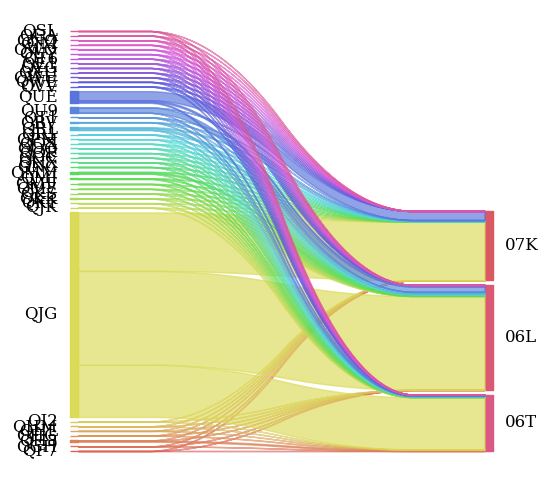

In [46]:
from pySankey.sankey import sankey
sankey (
    left = snee_referrals_2['Provider Parent org code'] , right = snee_referrals_2['Commissioner Org Code'],
    leftWeight = snee_referrals_2['Op Gprefsmade M'] , rightWeight = snee_referrals_2['Op Gprefsmade M'],
    fontsize = 12
)
plt.show()